In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from torch import nn, tensor, utils, optim, no_grad, Tensor
import torch

from micropyome.taxa import regression
from micropyome.datasets import normalize

DATASET_PATH = "../data/averill/bacteria/"
X = {}
Y = {}
for level in regression.TAXONOMIC_LEVELS:
    x = pd.read_csv(f"{DATASET_PATH}{level}/15_variables.csv")
    if level == 'fg':
        y = pd.read_csv(f"{DATASET_PATH}{level}/observed.csv")
    else:
        y = pd.read_csv(f"{DATASET_PATH}{level}/y_11groupTaxo.csv")

    x = x.drop(x.columns[0], axis=1)
    #x = normalize(x)
    scaler = StandardScaler()
    x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)


    y = y.drop(y.columns[0], axis=1)

    X[level] = x
    Y[level] = y


def graph_results(models: dict, results: dict):
    x = list(range(len(regression.TAXONOMIC_LEVELS)))

    for model in models:
        y = [results[level][model] for level in regression.TAXONOMIC_LEVELS]
        print(f"{model}: {y}")
        plt.plot(x, y, "-o", label=model)

    plt.xticks(x, regression.TAXONOMIC_LEVELS)
    plt.legend()
    plt.show()


def graph_results_no_fg(models: dict, results: dict):
    x = list(range(len(regression.TAXONOMIC_LEVELS[1:])))

    for model in models:
        y = [results[level][model] for level in regression.TAXONOMIC_LEVELS[1:]]
        print(f"{model}: {y}")
        plt.plot(x, y, "-o", label=model)

    plt.xticks(x, regression.TAXONOMIC_LEVELS[1:])
    plt.legend()
    plt.show()

In [9]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_in, n_in),
            nn.ReLU(),
            nn.Linear(n_in, 9),
            nn.ReLU(),
            nn.Linear(9, 6),
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(6, n_out),
            nn.LeakyReLU(),
            nn.Linear(n_out, n_out),
            nn.Softmax(1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


class AutoEncoderSigmoid(torch.nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_in, n_in),
            nn.Sigmoid(),
            nn.Linear(n_in, 9),
            nn.Sigmoid(),
            nn.Linear(9, 6),
            nn.Sigmoid(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(6, n_out),
            nn.Sigmoid(),
            nn.Linear(n_out, n_out),
            nn.Softmax(1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


class Predictor(torch.nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.predictor = nn.Sequential(
            nn.Linear(n_in, 6),
            nn.Sigmoid(),
            nn.Linear(6, 6),
            nn.Sigmoid(),
            nn.Linear(6, n_out),
            nn.Softmax(1)
        )

    def forward(self, x):
        return self.predictor(x)


class Regressor:
    def __init__(self, model, loss=None, epochs=None, optimizer=None):
        self.model_fn = model
        self.loss_function = loss
        self.epochs = epochs

    def fit(self, x, y):
        n_in = x.shape[1]
        n_out = y.shape[1]
        self.model = self.model_fn(n_in, n_out)
        self.optimizer = optim.Adagrad(self.model.parameters())
        if type(x) == pd.DataFrame:
            trainloader = utils.data.DataLoader(
                [(x, y) for x, y in zip(x.to_numpy(), y.to_numpy())], batch_size=64
            )
        else:
            trainloader = utils.data.DataLoader(
                [(x, y) for x, y in zip(x, y)], batch_size=256
            )
        for epoch in range(self.epochs):
            current_loss = 0.0
            #print(f"Epoch: {epoch}")
            for i, (inputs, outputs) in enumerate(trainloader, 0):
                inputs = inputs.float()
                outputs = outputs.float()
                self.optimizer.zero_grad()
                pred = self.model(inputs)
                loss = self.loss_function(pred, outputs)
                loss.backward()
                self.optimizer.step()
                current_loss += loss.item()
                if i % 5 == 0:
                    #print(f"Loss after mini-batch {i+1}: {current_loss}")
                    current_loss = 0.0

    def predict(self, x):
        self.model.eval()
        with no_grad():
            if type(x) == pd.DataFrame:
                x = x.to_numpy()
            outputs = self.model(Tensor(x))
            predicted_labels = outputs.squeeze().tolist()
        return predicted_labels

In [61]:
dataset = "genus"
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    X[dataset].values, Y[dataset].values, test_size=0.2, random_state=42
)

n_in = len(x_train[0])
n_out = len(y_train[0])
print(f"Map {n_in} features to {n_out} categories.")
print("Input:")
print(X[dataset].info())
print("Output:")
print(Y[dataset].describe())

Map 15 features to 11 categories.
Input:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1632 entries, 0 to 1631
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   1632 non-null   float64
 1   longitude  1632 non-null   float64
 2   depth_max  1632 non-null   float64
 3   forest     1632 non-null   float64
 4   map        1632 non-null   float64
 5   map_sd     1632 non-null   float64
 6   mat        1632 non-null   float64
 7   mat_sd     1632 non-null   float64
 8   map_CV     1632 non-null   float64
 9   mat_CV     1632 non-null   float64
 10  mdr        1632 non-null   float64
 11  aridity    1632 non-null   float64
 12  NPP        1632 non-null   float64
 13  relEM      1632 non-null   float64
 14  pH         1632 non-null   float64
dtypes: float64(15)
memory usage: 191.4 KB
None
Output:
             other     bacillus  bradyrhizobium  chthoniobacter      devosia  \
count  1632.000000  1632.000000     

In [71]:
regressor = Regressor(Predictor, nn.CrossEntropyLoss(), 50)
regressor.fit(x_train, y_train)
pred = regressor.predict(x_test)
p, t = pred[0], y_test[0]
for i, j in zip(p, t):
    print(f"{i:.4}    {j:.4}")


r2 = regression.r2_score_by_column(np.array(pred), y_test)
print(np.mean(r2))

0.9747    0.9649
0.002442    0.0009048
0.001728    0.002405
0.002257    0.00508
0.001036    0.0002548
0.00151    0.002405
0.005424    0.007779
0.001335    0.0007548
0.004221    0.00103
0.0009339    0.01273
0.004372    0.001755
-182920.1507719611


## MLP Compared to autoencoders

2024-07-28T16:47:45.744392 > INFO Evaluating 6 models with 5 splits.
2024-07-28T16:47:45.745392 > INFO Level: fg
2024-07-28T16:47:45.747759 > INFO K-fold split: 0
2024-07-28T16:47:45.749425 > INFO Beginning the evaluation of 6 models.
2024-07-28T16:47:47.394301 > INFO Dropped 4 columns.
2024-07-28T16:47:48.947695 > INFO Dropped 4 columns.
2024-07-28T16:47:51.167475 > INFO Dropped 4 columns.
2024-07-28T16:47:53.250298 > INFO Dropped 4 columns.
2024-07-28T16:47:55.524189 > INFO Dropped 4 columns.
2024-07-28T16:47:57.778374 > INFO Dropped 4 columns.
2024-07-28T16:47:57.788415 > INFO K-fold split: 1
2024-07-28T16:47:57.793542 > INFO Beginning the evaluation of 6 models.
2024-07-28T16:47:59.762779 > INFO Dropped 4 columns.
2024-07-28T16:48:01.585300 > INFO Dropped 4 columns.
2024-07-28T16:48:03.558442 > INFO Dropped 4 columns.
2024-07-28T16:48:05.432532 > INFO Dropped 4 columns.
2024-07-28T16:48:07.426067 > INFO Dropped 4 columns.
2024-07-28T16:48:09.350790 > INFO Dropped 4 columns.
2024-07

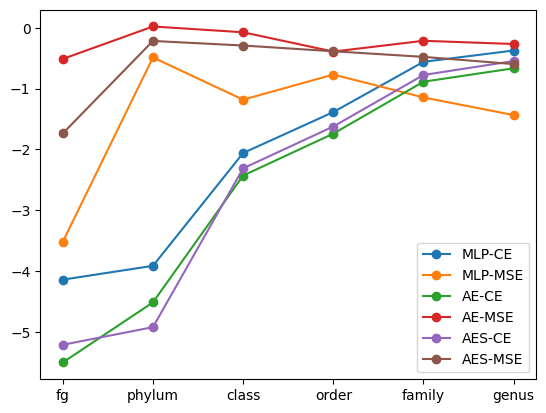

In [80]:
models = {
    "MLP-CE": Regressor(Predictor, nn.CrossEntropyLoss(), 50),
    "MLP-MSE": Regressor(Predictor, nn.MSELoss(), 50),
    "AE-CE": Regressor(AutoEncoder, nn.CrossEntropyLoss(), 50),
    "AE-MSE": Regressor(AutoEncoder, nn.MSELoss(), 50),
    "AES-CE": Regressor(AutoEncoderSigmoid, nn.CrossEntropyLoss(), 50),
    "AES-MSE": Regressor(AutoEncoderSigmoid, nn.MSELoss(), 50),
}
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.003, k_fold=5)
graph_results(models, results)

## Autoencoders

2024-07-28T16:56:07.296621 > INFO Evaluating 1 models with 5 splits.
2024-07-28T16:56:07.298231 > INFO Level: fg
2024-07-28T16:56:07.300253 > INFO K-fold split: 0
2024-07-28T16:56:07.303781 > INFO Beginning the evaluation of 1 models.
2024-07-28T16:56:09.223400 > INFO Dropped 4 columns.
2024-07-28T16:56:09.233421 > INFO K-fold split: 1
2024-07-28T16:56:09.238441 > INFO Beginning the evaluation of 1 models.
2024-07-28T16:56:11.285239 > INFO Dropped 4 columns.
2024-07-28T16:56:11.293757 > INFO K-fold split: 2
2024-07-28T16:56:11.300285 > INFO Beginning the evaluation of 1 models.
2024-07-28T16:56:13.537588 > INFO Dropped 3 columns.
2024-07-28T16:56:13.547124 > INFO K-fold split: 3
2024-07-28T16:56:13.554325 > INFO Beginning the evaluation of 1 models.
2024-07-28T16:56:15.444608 > INFO Dropped 4 columns.
2024-07-28T16:56:15.453838 > INFO K-fold split: 4
2024-07-28T16:56:15.457847 > INFO Beginning the evaluation of 1 models.
2024-07-28T16:56:17.347244 > INFO Dropped 4 columns.
2024-07-28T1

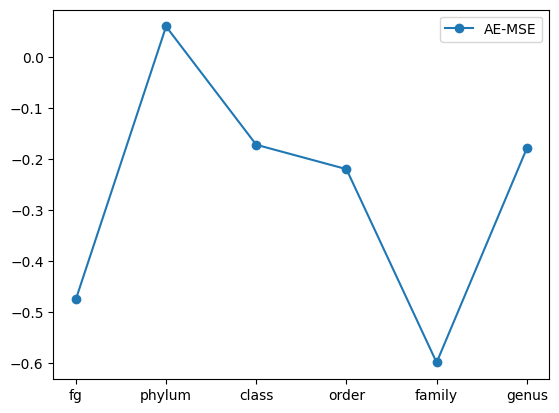

In [81]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_in, n_in),
            nn.ReLU(),
            nn.Linear(n_in, 9),
            nn.ReLU(),
            nn.Linear(9, 6),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(6, n_out),
            nn.ReLU(),
            nn.Linear(n_out, n_out),
            nn.Softmax(1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


models = {
    "AE-MSE": Regressor(AutoEncoder, nn.MSELoss(), 50),
}
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.003, k_fold=5)
graph_results(models, results)

2024-07-28T19:44:17.500023 > INFO Evaluating 4 models with 5 splits.
2024-07-28T19:44:17.501998 > INFO Level: fg
2024-07-28T19:44:17.503761 > INFO K-fold split: 0
2024-07-28T19:44:17.507689 > INFO Beginning the evaluation of 4 models.
2024-07-28T19:44:18.457420 > INFO Dropped 4 columns.
2024-07-28T19:44:22.688549 > INFO Dropped 4 columns.
2024-07-28T19:44:29.283692 > INFO Dropped 4 columns.
2024-07-28T19:44:37.322759 > INFO Dropped 4 columns.
2024-07-28T19:44:37.328442 > INFO K-fold split: 1
2024-07-28T19:44:37.337489 > INFO Beginning the evaluation of 4 models.
2024-07-28T19:44:38.317845 > INFO Dropped 4 columns.
2024-07-28T19:44:42.221502 > INFO Dropped 4 columns.
2024-07-28T19:44:47.959199 > INFO Dropped 4 columns.
2024-07-28T19:44:56.138381 > INFO Dropped 4 columns.
2024-07-28T19:44:56.150428 > INFO K-fold split: 2
2024-07-28T19:44:56.158125 > INFO Beginning the evaluation of 4 models.
2024-07-28T19:44:57.138146 > INFO Dropped 4 columns.
2024-07-28T19:45:01.047546 > INFO Dropped 4 

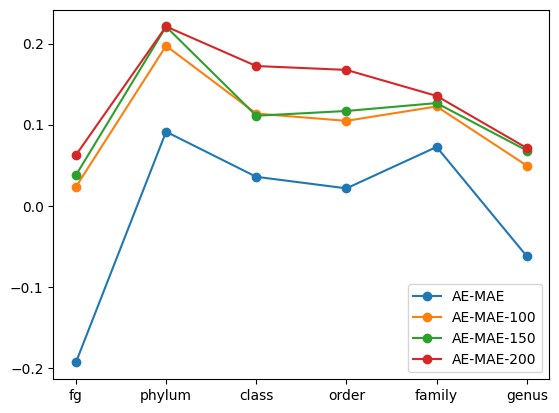

In [98]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_in, n_in),
            nn.ReLU(),
            nn.Linear(n_in, 9),
            nn.ReLU(),
            nn.Linear(9, 9),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(9, n_out),
            nn.ReLU(),
            nn.Linear(n_out, n_out),
            nn.Softmax(1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


models = {
    "AE-MAE": Regressor(AutoEncoder, nn.L1Loss(), 25),
    "AE-MAE-100": Regressor(AutoEncoder, nn.L1Loss(), 100),
    "AE-MAE-150": Regressor(AutoEncoder, nn.L1Loss(), 150),
    "AE-MAE-200": Regressor(AutoEncoder, nn.L1Loss(), 200),
}
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.003, k_fold=5)
graph_results(models, results)

2024-07-29T19:30:17.872405 > INFO Evaluating 2 models with 5 splits.
2024-07-29T19:30:17.873234 > INFO Level: fg
2024-07-29T19:30:17.875745 > INFO K-fold split: 0
2024-07-29T19:30:17.898503 > INFO Beginning the evaluation of 2 models.
2024-07-29T19:30:22.348242 > INFO Dropped 4 columns.
2024-07-29T19:30:26.391521 > INFO Dropped 4 columns.
2024-07-29T19:30:26.399023 > INFO K-fold split: 1
2024-07-29T19:30:26.407050 > INFO Beginning the evaluation of 2 models.
2024-07-29T19:30:27.448190 > INFO Dropped 4 columns.
2024-07-29T19:30:31.963832 > INFO Dropped 4 columns.
2024-07-29T19:30:31.971923 > INFO K-fold split: 2
2024-07-29T19:30:31.979351 > INFO Beginning the evaluation of 2 models.
2024-07-29T19:30:32.968916 > INFO Dropped 4 columns.
2024-07-29T19:30:37.018857 > INFO Dropped 4 columns.
2024-07-29T19:30:37.027901 > INFO K-fold split: 3
2024-07-29T19:30:37.032410 > INFO Beginning the evaluation of 2 models.
2024-07-29T19:30:38.135852 > INFO Dropped 4 columns.
2024-07-29T19:30:42.161067 >

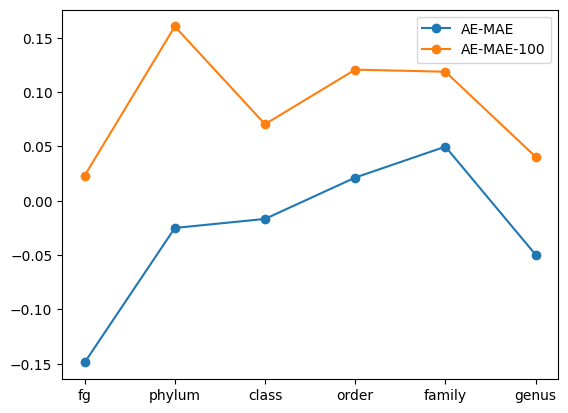

In [3]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        N_INTERMEDIATE = 6
        self.encoder = nn.Sequential(
            nn.Linear(n_in, n_in),
            nn.ReLU(),
            nn.Linear(n_in, N_INTERMEDIATE),
            nn.ReLU(),
            nn.Linear(N_INTERMEDIATE, N_INTERMEDIATE),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(N_INTERMEDIATE, n_out),
            nn.ReLU(),
            nn.Linear(n_out, n_out),
            nn.Softmax(1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


models = {
    "AE-MAE": Regressor(AutoEncoder, nn.L1Loss(), 25),
    "AE-MAE-100": Regressor(AutoEncoder, nn.L1Loss(), 100),
}
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.003, k_fold=5)
graph_results(models, results)

2024-07-29T19:45:37.550335 > INFO Evaluating 2 models with 5 splits.
2024-07-29T19:45:37.552020 > INFO Level: fg
2024-07-29T19:45:37.554144 > INFO K-fold split: 0
2024-07-29T19:45:37.557667 > INFO Beginning the evaluation of 2 models.
2024-07-29T19:45:39.714378 > INFO Dropped 3 columns.
2024-07-29T19:45:44.046807 > INFO Dropped 3 columns.
2024-07-29T19:45:44.053522 > INFO K-fold split: 1
2024-07-29T19:45:44.063532 > INFO Beginning the evaluation of 2 models.
2024-07-29T19:45:46.246752 > INFO Dropped 4 columns.
2024-07-29T19:45:50.346550 > INFO Dropped 4 columns.
2024-07-29T19:45:50.353306 > INFO K-fold split: 2
2024-07-29T19:45:50.362847 > INFO Beginning the evaluation of 2 models.
2024-07-29T19:45:52.423181 > INFO Dropped 4 columns.
2024-07-29T19:45:56.513027 > INFO Dropped 4 columns.
2024-07-29T19:45:56.526575 > INFO K-fold split: 3
2024-07-29T19:45:56.533338 > INFO Beginning the evaluation of 2 models.
2024-07-29T19:45:58.576683 > INFO Dropped 4 columns.
2024-07-29T19:46:03.010264 >

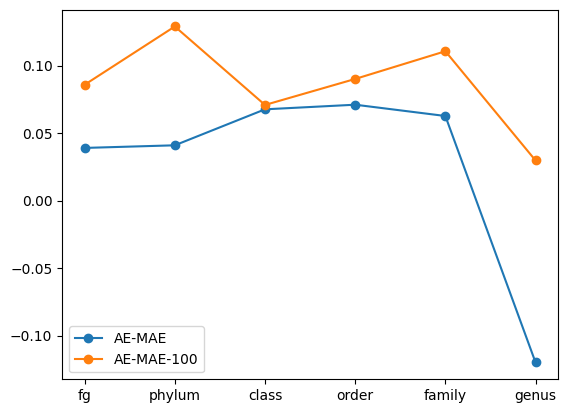

In [7]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        N_INTERMEDIATE = 6
        self.encoder = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(n_in, n_in),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(n_in, N_INTERMEDIATE),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(N_INTERMEDIATE, N_INTERMEDIATE),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(N_INTERMEDIATE, n_out),
            nn.ReLU(),
            nn.Linear(n_out, n_out),
            nn.Softmax(1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


models = {
    "AE-MAE": Regressor(AutoEncoder, nn.L1Loss(), 50),
    "AE-MAE-100": Regressor(AutoEncoder, nn.L1Loss(), 100),
}
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.003, k_fold=5)
graph_results(models, results)

## CNN

2024-07-29T20:21:46.796159 > INFO Evaluating 2 models with 5 splits.
2024-07-29T20:21:46.797139 > INFO Level: fg
2024-07-29T20:21:46.797139 > INFO K-fold split: 0
2024-07-29T20:21:46.804043 > INFO Beginning the evaluation of 2 models.
2024-07-29T20:21:49.595213 > INFO Dropped 4 columns.
2024-07-29T20:21:58.975177 > INFO Dropped 4 columns.
2024-07-29T20:21:58.982463 > INFO K-fold split: 1
2024-07-29T20:21:58.990987 > INFO Beginning the evaluation of 2 models.
2024-07-29T20:22:01.305042 > INFO Dropped 4 columns.
2024-07-29T20:22:10.899826 > INFO Dropped 4 columns.
2024-07-29T20:22:10.909863 > INFO K-fold split: 2
2024-07-29T20:22:10.913587 > INFO Beginning the evaluation of 2 models.
2024-07-29T20:22:13.211423 > INFO Dropped 4 columns.
2024-07-29T20:22:22.440656 > INFO Dropped 4 columns.
2024-07-29T20:22:22.445169 > INFO K-fold split: 3
2024-07-29T20:22:22.451403 > INFO Beginning the evaluation of 2 models.
2024-07-29T20:22:25.114188 > INFO Dropped 4 columns.
2024-07-29T20:22:34.618028 >

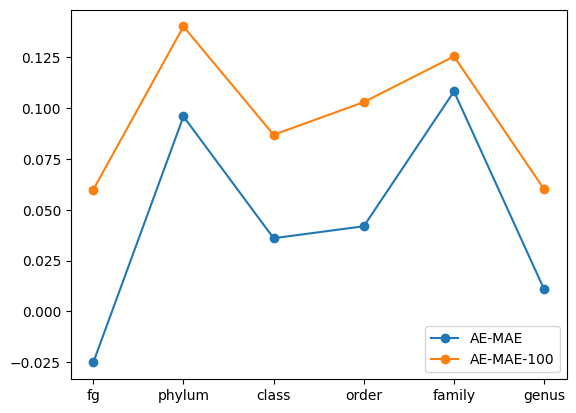

In [16]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        N_INTERMEDIATE = 6
        self.encoder = nn.Sequential(
            nn.Linear(n_in, n_in),
            nn.ReLU(),
            nn.Linear(n_in, N_INTERMEDIATE),
            nn.ReLU(),
            nn.Linear(N_INTERMEDIATE, N_INTERMEDIATE),
            nn.ReLU(),
        )
        self.conv = nn.Conv1d(6, 6, 3, padding="same")
        self.decoder = nn.Sequential(
            nn.Linear(N_INTERMEDIATE, n_out),
            nn.ReLU(),
            nn.Linear(n_out, n_out),
            nn.Softmax(1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = self.conv(encoded.T).T
        decoded = self.decoder(encoded)
        return decoded


models = {
    "AE-MAE": Regressor(AutoEncoder, nn.L1Loss(), 50),
    "AE-MAE-100": Regressor(AutoEncoder, nn.L1Loss(), 100),
    "AE-MAE-100": Regressor(AutoEncoder, nn.L1Loss(), 200),
}
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.003, k_fold=5)
graph_results(models, results)

2024-07-29T21:35:47.542819 > INFO Evaluating 3 models with 5 splits.
2024-07-29T21:35:47.543898 > INFO Level: fg
2024-07-29T21:35:47.546879 > INFO K-fold split: 0
2024-07-29T21:35:47.551046 > INFO Beginning the evaluation of 3 models.
2024-07-29T21:35:49.531249 > INFO Dropped 3 columns.
2024-07-29T21:35:53.797416 > INFO Dropped 3 columns.
2024-07-29T21:36:01.857119 > INFO Dropped 3 columns.
2024-07-29T21:36:01.866146 > INFO K-fold split: 1
2024-07-29T21:36:01.871660 > INFO Beginning the evaluation of 3 models.
2024-07-29T21:36:03.818713 > INFO Dropped 4 columns.
2024-07-29T21:36:07.757263 > INFO Dropped 4 columns.
2024-07-29T21:36:15.440000 > INFO Dropped 4 columns.
2024-07-29T21:36:15.450018 > INFO K-fold split: 2
2024-07-29T21:36:15.454018 > INFO Beginning the evaluation of 3 models.
2024-07-29T21:36:17.391337 > INFO Dropped 4 columns.
2024-07-29T21:36:21.239531 > INFO Dropped 4 columns.
2024-07-29T21:36:28.999884 > INFO Dropped 4 columns.
2024-07-29T21:36:29.007155 > INFO K-fold spl

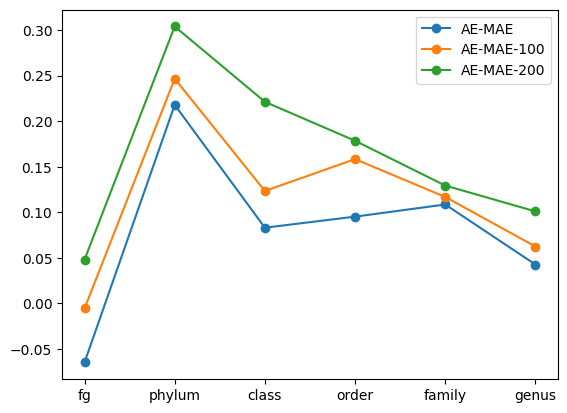

In [22]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        N_INTERMEDIATE = 16
        self.encoder = nn.Sequential(
            nn.Linear(n_in, 32),
            nn.ReLU(),
            nn.Linear(32, N_INTERMEDIATE),
            nn.ReLU(),
            nn.Linear(N_INTERMEDIATE, N_INTERMEDIATE),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(N_INTERMEDIATE, n_out),
            nn.ReLU(),
            nn.Linear(n_out, n_out),
            nn.Softmax(1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


models = {
    "AE-MAE": Regressor(AutoEncoder, nn.L1Loss(), 50),
    "AE-MAE-100": Regressor(AutoEncoder, nn.L1Loss(), 100),
    "AE-MAE-200": Regressor(AutoEncoder, nn.L1Loss(), 200),
}
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.003, k_fold=5)
graph_results(models, results)

2024-07-30T23:20:08.597316 > INFO Evaluating 5 models with 5 splits.
2024-07-30T23:20:08.601029 > INFO Level: fg
2024-07-30T23:20:08.607907 > INFO K-fold split: 0
2024-07-30T23:20:08.619649 > INFO Beginning the evaluation of 5 models.
2024-07-30T23:20:10.866391 > INFO Dropped 3 columns.
2024-07-30T23:20:15.268273 > INFO Dropped 3 columns.
2024-07-30T23:20:23.426995 > INFO Dropped 3 columns.
2024-07-30T23:20:32.997833 > INFO Dropped 3 columns.
2024-07-30T23:20:44.470942 > INFO Dropped 3 columns.
2024-07-30T23:20:44.480162 > INFO K-fold split: 1
2024-07-30T23:20:44.485124 > INFO Beginning the evaluation of 5 models.
2024-07-30T23:20:46.619554 > INFO Dropped 4 columns.
2024-07-30T23:20:50.868039 > INFO Dropped 4 columns.
2024-07-30T23:20:59.543991 > INFO Dropped 4 columns.
2024-07-30T23:21:09.653738 > INFO Dropped 4 columns.
2024-07-30T23:21:21.661359 > INFO Dropped 4 columns.
2024-07-30T23:21:21.671373 > INFO K-fold split: 2
2024-07-30T23:21:21.676379 > INFO Beginning the evaluation of 5

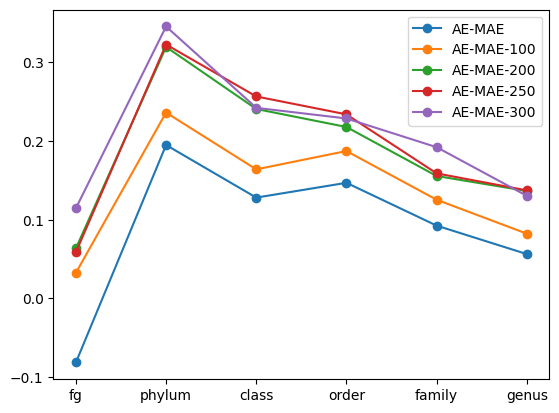

2024-07-30T23:39:23.616994 > INFO Evaluating 5 models with 5 splits.
2024-07-30T23:39:23.616994 > INFO Level: fg
2024-07-30T23:39:23.616994 > INFO K-fold split: 0
2024-07-30T23:39:23.626034 > INFO Beginning the evaluation of 5 models.
2024-07-30T23:40:01.096779 > INFO K-fold split: 1
2024-07-30T23:40:01.096779 > INFO Beginning the evaluation of 5 models.
2024-07-30T23:40:38.940524 > INFO K-fold split: 2
2024-07-30T23:40:38.946953 > INFO Beginning the evaluation of 5 models.
2024-07-30T23:41:21.535814 > INFO K-fold split: 3
2024-07-30T23:41:21.539122 > INFO Beginning the evaluation of 5 models.
2024-07-30T23:41:58.777360 > INFO K-fold split: 4
2024-07-30T23:41:58.778373 > INFO Beginning the evaluation of 5 models.
2024-07-30T23:42:35.812542 > INFO Level: phylum
2024-07-30T23:42:35.818067 > INFO K-fold split: 0
2024-07-30T23:42:35.818802 > INFO Beginning the evaluation of 5 models.
2024-07-30T23:43:14.490543 > INFO K-fold split: 1
2024-07-30T23:43:14.490543 > INFO Beginning the evaluatio

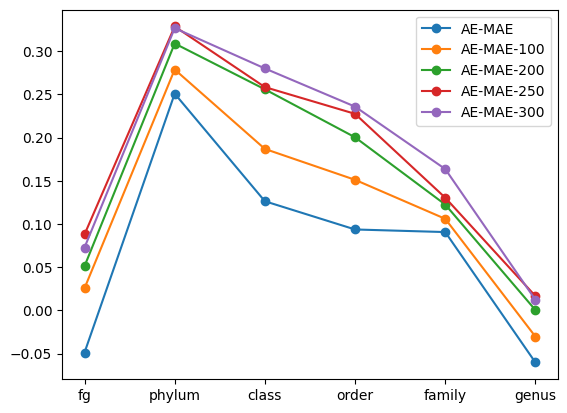

In [28]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_in, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, n_out),
            nn.ReLU(),
            nn.Linear(n_out, n_out),
            nn.Softmax(1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


models = {
    "AE-MAE": Regressor(AutoEncoder, nn.L1Loss(), 50),
    "AE-MAE-100": Regressor(AutoEncoder, nn.L1Loss(), 100),
    "AE-MAE-200": Regressor(AutoEncoder, nn.L1Loss(), 200),
    "AE-MAE-250": Regressor(AutoEncoder, nn.L1Loss(), 250),
    "AE-MAE-300": Regressor(AutoEncoder, nn.L1Loss(), 300),
}
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.003, k_fold=5)
graph_results(models, results)
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.000, k_fold=5)
graph_results(models, results)

## Averill Fungi

In [10]:
DATASET_PATH = "../data/averill/fungi/"
X = {}
Y = {}

for level in regression.TAXONOMIC_LEVELS:
    x = pd.read_csv(f"{DATASET_PATH}{level}/13_variables.csv")
    y = pd.read_csv(f"{DATASET_PATH}{level}/observed.csv")

    x = x.drop(x.columns[0], axis=1) # Drop the ID of the sample.
    # Scale features to remove the mean and make the variance unitary.
    scaler = StandardScaler()
    x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

    y = y.drop(y.columns[0], axis=1) # Drop the ID of the sample.
    if level == "phylum":
        y = y.drop(columns=["other"])  # Special case to avoid poor predictions.

    X[level] = x
    Y[level] = y

2024-09-16T22:22:55.051606 > INFO Evaluating 2 models with 5 splits.
2024-09-16T22:22:55.053743 > INFO Level: fg
2024-09-16T22:22:55.055688 > INFO K-fold split: 0
2024-09-16T22:22:55.058953 > INFO Beginning the evaluation of 2 models.
2024-09-16T22:23:04.245112 > INFO Dropped 2 columns.
2024-09-16T22:23:04.614962 > INFO Dropped 2 columns.
2024-09-16T22:23:04.628467 > INFO K-fold split: 1
2024-09-16T22:23:04.628467 > INFO Beginning the evaluation of 2 models.
2024-09-16T22:23:04.814780 > INFO Dropped 0 columns.
2024-09-16T22:23:05.173183 > INFO Dropped 0 columns.
2024-09-16T22:23:05.173183 > INFO K-fold split: 2
2024-09-16T22:23:05.173183 > INFO Beginning the evaluation of 2 models.
2024-09-16T22:23:05.407774 > INFO Dropped 1 columns.
2024-09-16T22:23:05.762043 > INFO Dropped 1 columns.
2024-09-16T22:23:05.762043 > INFO K-fold split: 3
2024-09-16T22:23:05.762043 > INFO Beginning the evaluation of 2 models.
2024-09-16T22:23:05.962292 > INFO Dropped 2 columns.
2024-09-16T22:23:06.330139 >

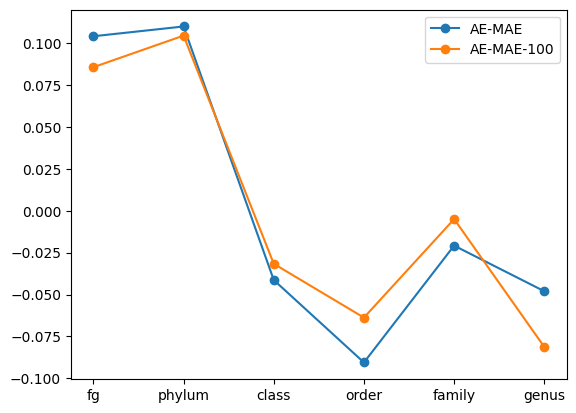

2024-09-16T22:23:23.022082 > INFO Evaluating 2 models with 5 splits.
2024-09-16T22:23:23.023144 > INFO Level: fg
2024-09-16T22:23:23.024557 > INFO K-fold split: 0
2024-09-16T22:23:23.028885 > INFO Beginning the evaluation of 2 models.
2024-09-16T22:23:23.850612 > INFO K-fold split: 1
2024-09-16T22:23:23.850612 > INFO Beginning the evaluation of 2 models.
2024-09-16T22:23:24.564743 > INFO K-fold split: 2
2024-09-16T22:23:24.564743 > INFO Beginning the evaluation of 2 models.
2024-09-16T22:23:25.388538 > INFO K-fold split: 3
2024-09-16T22:23:25.388538 > INFO Beginning the evaluation of 2 models.
2024-09-16T22:23:26.184068 > INFO K-fold split: 4
2024-09-16T22:23:26.184068 > INFO Beginning the evaluation of 2 models.
2024-09-16T22:23:26.802595 > INFO Level: phylum
2024-09-16T22:23:26.804597 > INFO K-fold split: 0
2024-09-16T22:23:26.808597 > INFO Beginning the evaluation of 2 models.
2024-09-16T22:23:27.446706 > INFO K-fold split: 1
2024-09-16T22:23:27.450708 > INFO Beginning the evaluatio

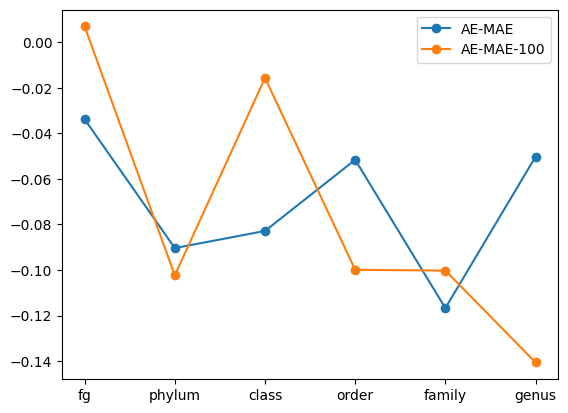

In [11]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_in, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, n_out),
            nn.ReLU(),
            nn.Linear(n_out, n_out),
            nn.Softmax(1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


models = {
    "AE-MAE": Regressor(AutoEncoder, nn.L1Loss(), 50),
    "AE-MAE-100": Regressor(AutoEncoder, nn.L1Loss(), 100)
}
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.01, k_fold=5)
graph_results(models, results)
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.0, k_fold=5)
graph_results(models, results)

## NEON Bacteria

In [15]:
DATASET_PATH = "../data/neon/bacteria/"
X = {}
Y = {}
for level in regression.TAXONOMIC_LEVELS:
    if level == 'fg':
        continue
    x = pd.read_csv(f"{DATASET_PATH}var_sorted.csv", sep=";")
    y = pd.read_csv(f"{DATASET_PATH}Observed/{level}.csv", sep=";")

    x = x.drop(columns=x.columns[:5], axis=1)
    if "deprecatedVialID" in x.columns:
        x = x.drop("deprecatedVialID", axis=1)
    scaler = StandardScaler()
    x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
    y = y.drop(y.columns[0], axis=1)

    X[level] = x
    Y[level] = y

In [17]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_in, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, n_out),
            nn.ReLU(),
            nn.Linear(n_out, n_out),
            nn.Softmax(1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


models = {
    "AE-MAE": Regressor(AutoEncoder, nn.L1Loss(), 50),
    "AE-MAE-100": Regressor(AutoEncoder, nn.L1Loss(), 100)
}
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.003, k_fold=5)

2024-09-16T22:44:37.824732 > INFO Evaluating 2 models with 5 splits.
2024-09-16T22:44:37.827244 > INFO Level: fg
2024-09-16T22:44:37.828753 > INFO Level: phylum
2024-09-16T22:44:37.830755 > INFO K-fold split: 0
2024-09-16T22:44:37.833955 > INFO Beginning the evaluation of 2 models.
2024-09-16T22:44:38.216097 > INFO Dropped 0 columns.
2024-09-16T22:44:39.021649 > INFO Dropped 0 columns.
2024-09-16T22:44:39.031677 > INFO K-fold split: 1
2024-09-16T22:44:39.034675 > INFO Beginning the evaluation of 2 models.
2024-09-16T22:44:39.447205 > INFO Dropped 0 columns.
2024-09-16T22:44:40.377598 > INFO Dropped 0 columns.
2024-09-16T22:44:40.387143 > INFO K-fold split: 2
2024-09-16T22:44:40.393744 > INFO Beginning the evaluation of 2 models.
2024-09-16T22:44:40.857290 > INFO Dropped 0 columns.
2024-09-16T22:44:41.646864 > INFO Dropped 0 columns.
2024-09-16T22:44:41.657943 > INFO K-fold split: 3
2024-09-16T22:44:41.660969 > INFO Beginning the evaluation of 2 models.
2024-09-16T22:44:42.084048 > INFO

KeyError: 'fg'

AE-MAE: [0.048597713777535904, 0.026765538571132636, -0.027564039318027266, -0.13728363993171389, -0.7151799392118818]
AE-MAE-100: [0.21756287919198075, 0.1517576171979957, 0.02007979522615177, 0.02174300893663356, 0.00010382461179467284]


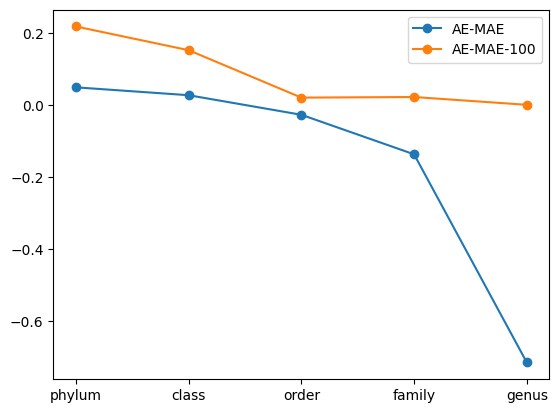

In [18]:
graph_results_no_fg(models, results)

## NEON Fungi

In [19]:
from micropyome.datasets import normalize, normalize_categories

TRANSFER_DATASET_PATH = "../data/neon/fungi/"
SAMPLING_LEVELS = ["core", "plot", "site"]

X = {}
Y = {}
Y2 = {}

for level in regression.TAXONOMIC_LEVELS:
    X[level] = {}
    Y[level] = {}
    Y2[level] = {}
    x = pd.read_csv(f"{TRANSFER_DATASET_PATH}/Variables/{level}_core_13Var.csv", delimiter=";")
    x = x.drop(x.columns[0], axis=1)
    x = normalize(x)
    y = pd.read_csv(f"{TRANSFER_DATASET_PATH}/Observed/{level}_core_observed.csv")
    y = y.drop(y.columns[0], axis=1)
    y = normalize_categories(y)
    z = pd.read_csv(f"{TRANSFER_DATASET_PATH}/Predicted/{level}_core_predicted.csv")
    z = z.drop(z.columns[0], axis=1)
    z = normalize_categories(z)
    X[level] = x
    Y[level] = y
    Y2[level] = z

In [20]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_in, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, n_out),
            nn.ReLU(),
            nn.Linear(n_out, n_out),
            nn.Softmax(1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


models = {
    "AE-MAE": Regressor(AutoEncoder, nn.L1Loss(), 50),
    "AE-MAE-100": Regressor(AutoEncoder, nn.L1Loss(), 100)
}
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, threshold=0.01, k_fold=5)

2024-09-16T22:46:39.537112 > INFO Evaluating 2 models with 5 splits.
2024-09-16T22:46:39.539575 > INFO Level: fg
2024-09-16T22:46:39.541580 > INFO K-fold split: 0
2024-09-16T22:46:39.546005 > INFO Beginning the evaluation of 2 models.
2024-09-16T22:46:39.987176 > INFO Dropped 1 columns.
2024-09-16T22:46:40.781334 > INFO Dropped 1 columns.
2024-09-16T22:46:40.787957 > INFO K-fold split: 1
2024-09-16T22:46:40.790485 > INFO Beginning the evaluation of 2 models.
2024-09-16T22:46:41.180996 > INFO Dropped 1 columns.
2024-09-16T22:46:41.957786 > INFO Dropped 1 columns.
2024-09-16T22:46:41.961547 > INFO K-fold split: 2
2024-09-16T22:46:41.967096 > INFO Beginning the evaluation of 2 models.
2024-09-16T22:46:42.361414 > INFO Dropped 1 columns.
2024-09-16T22:46:43.147089 > INFO Dropped 1 columns.
2024-09-16T22:46:43.149102 > INFO K-fold split: 3
2024-09-16T22:46:43.157128 > INFO Beginning the evaluation of 2 models.
2024-09-16T22:46:43.558758 > INFO Dropped 1 columns.
2024-09-16T22:46:44.477795 >

AE-MAE: [0.06628361544323248, -1.9184890483467965, 0.06579769939696607, -0.0603038118002729, -0.07484865541760638, -0.14524665579968854]
AE-MAE-100: [0.20861611787948192, 0.0594476896538504, 0.11830167423501399, -0.011086980029600147, -0.00048218287561686417, -0.0786023493938269]


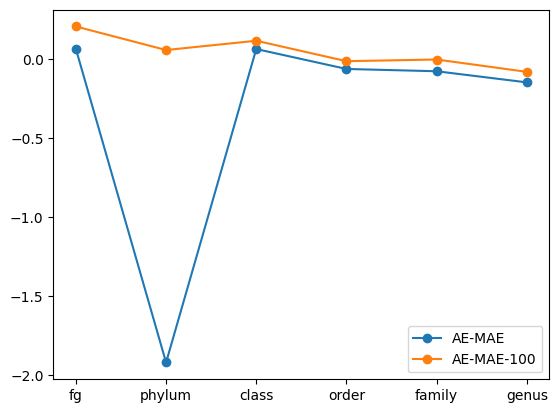

In [21]:
graph_results(models, results)